<div style="font-family: 'Segoe UI', 'Helvetica Neue', Arial, sans-serif; line-height: 1.6;">

<h1 style="color: #3498db; border-bottom: 3px solid #3498db; padding-bottom: 10px;">
    Exploratory Data Analysis of Air Quality in Nairobi
</h1>

<h2 style="color: #3498db;">What is Exploratory Data Analysis (EDA)?</h2>

<blockquote style="border-left: 4px solid #3498db; padding-left: 20px; color: #555; font-style: italic;">
Exploratory Data Analysis (EDA) is the crucial first step in any data analysis project. It's a process of investigation and discovery, where we use statistical summaries and data visualization techniques to better understand a dataset.
</blockquote>

The primary goals of EDA are to:
<ul>
    <li style="margin-bottom: 8px;">✅   <strong>Ask meaningful questions</strong> about the data to guide our analysis.</li>
    <li style="margin-bottom: 8px;">✅   <strong>Identify the underlying structure</strong> and key variables within the dataset.</li>
    <li style="margin-bottom: 8px;">✅   <strong>Detect trends, patterns, and anomalies</strong> such as outliers or unexpected distributions.</li>
    <li style="margin-bottom: 8px;">✅   <strong>Test hypotheses</strong> and validate assumptions about the data.</li>
    <li style="margin-bottom: 8px;">✅   <strong>Uncover potential problems</strong> and inform which analytical techniques are most appropriate.</li>
</ul>

In this notebook, we will perform a complete EDA on air quality forecast data for Nairobi, Kenya, sourced from the <span style="color: #3498db; font-weight: bold;">World Air Quality Index (WAQI) API</span>.

<br>

<h2 style="color: #3498db; border-bottom: 2px solid #ccc; padding-bottom: 8px;">1. Setup and Data Acquisition</h2>

First, we'll set up our environment by importing the necessary Python libraries and securely loading our API credentials.

<h3 style="color: #3498db;">1.1. Load Libraries and API Token</h3>
It's a critical security practice to never expose sensitive information like API tokens directly in your code. We'll use a <code style="background-color: #f0f0f0; border-radius: 4px; padding: 2px 6px; color: #c7254e;">.env</code> file to store our token and the <code style="background-color: #f0f0f0; border-radius: 4px; padding: 2px 6px; color: #c7254e;">dotenv</code> library to load it into our environment.

In [17]:
import requests
from dotenv import load_dotenv, find_dotenv
import os

# Load environment variables
load_dotenv(find_dotenv())

# Get your token securely
WAQI_TOKEN = os.getenv("WAQI_TOKEN")

# Make sure your token is loaded
if not WAQI_TOKEN:
    raise ValueError("API token not found. Please set WAQI_TOKEN in your .env file.")
else:
    print("API token loaded successfully!")

API token loaded successfully!


<h3 style="color: #3498db;">1.2. Query the WAQI API for Nairobi Data</h3>
With our token ready, we can now make a request to the WAQI API to fetch the current and forecasted air quality data for Nairobi.

In [18]:
city = "nairobi"
url = f"https://api.waqi.info/feed/{city}/?token={WAQI_TOKEN}"

try:
    response = requests.get(url)
    response.raise_for_status()  # Raises an HTTPError for bad responses (4xx or 5xx)
    data = response.json()
    print(f"Successfully fetched data for: {data['data']['city']['name']}")
except requests.exceptions.HTTPError as http_err:
    print(f"HTTP error occurred: {http_err}")
except requests.exceptions.RequestException as err:
    print(f"An error occurred: {err}")
except KeyError:
    print("Could not parse city name from the response. The data structure might have changed.")

Successfully fetched data for: Nairobi US Embassy, Kenya


<h2 style="color: #3498db; border-bottom: 2px solid #ccc; padding-bottom: 8px;">2. Data Processing and Transformation</h2>

API data often comes in a nested JSON format, which is not ideal for analysis. Our next step is to process and transform this data into a structured <code style="background-color: #f0f0f0; border-radius: 4px; padding: 2px 6px; color: #c7254e;">pandas</code> DataFrame, which is the standard tool for data manipulation in Python.

We will create two main DataFrames:
<ul>
    <li><strong><code style="background-color: #f0f0f0; border-radius: 4px; padding: 2px 6px; color: #c7254e;">df_forecast_long</code></strong>: A "long-format" table where each row represents a single pollutant's forecast for a single day. This format is excellent for certain types of plotting and aggregation.</li>
    <li><strong><code style="background-color: #f0f0f0; border-radius: 4px; padding: 2px 6px; color: #c7254e;">df_forecast_pivot</code></strong>: A "wide-format" table where dates are the index, and each pollutant has its own column. This format is intuitive and very useful for comparing pollutants over time.</li>
</ul>

In [20]:
import pandas as pd

# Check if the API request was successful and data is present
if data.get("status") == "ok":
    
    # --- Process Forecast Data ---
    forecast_data = data["data"].get("forecast", {}).get("daily", {})
    all_forecast_records = []

    for pollutant, records in forecast_data.items():
        # Create a temporary DataFrame for the current pollutant
        df_pollutant = pd.DataFrame(records)
        # Add a column to identify the pollutant
        df_pollutant["pollutant"] = pollutant
        all_forecast_records.append(df_pollutant)

    # Concatenate all pollutant records into a single long-format DataFrame
    if all_forecast_records:
        df_forecast_long = pd.concat(all_forecast_records, ignore_index=True)
        
        # Convert the 'day' column to a proper datetime format
        df_forecast_long['day'] = pd.to_datetime(df_forecast_long['day'])
        
        print("--- Long-Format Forecast DataFrame ---")
        print(df_forecast_long.head())
        print("\nDataFrame Info:")
        df_forecast_long.info()

        # --- Create a Pivoted (Wide-Format) DataFrame ---
        # This makes it easy to compare pollutants side-by-side
        df_forecast_pivot = df_forecast_long.pivot(
            index="day", 
            columns="pollutant", 
            values="avg"
        )
        
        print("\n\n--- Pivoted (Wide-Format) Forecast DataFrame ---")
        print(df_forecast_pivot.head())

    else:
        print("No forecast data was available to process.")
        df_forecast_pivot = pd.DataFrame() # Create an empty df to avoid errors later

else:
    print(f"Could not retrieve data. Status: {data.get('status')}")
    df_forecast_pivot = pd.DataFrame() # Create an empty df to avoid errors later

--- Long-Format Forecast DataFrame ---
   avg        day  max  min pollutant
0   11 2025-02-05   17    7        o3
1   10 2025-02-06   15    6        o3
2    7 2025-02-07   11    3        o3
3    8 2025-02-08   12    4        o3
4    8 2025-02-09   14    2        o3

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   avg        30 non-null     int64         
 1   day        30 non-null     datetime64[ns]
 2   max        30 non-null     int64         
 3   min        30 non-null     int64         
 4   pollutant  30 non-null     object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 1.3+ KB


--- Pivoted (Wide-Format) Forecast DataFrame ---
pollutant     o3  pm10  pm25  uvi
day                              
2025-02-05  11.0  55.0  86.0  NaN
2025-02-06  10.0  42.0  72.0  NaN
2025-02-07   7.0  31.0  51.0 

<h2 style="color: #3498db; border-bottom: 2px solid #ccc; padding-bottom: 8px;">3. Exploratory Data Analysis</h2>

Now that our data is clean and structured, we can begin the exploration. We will ask a series of questions to uncover insights.

<h3 style="color: #3498db;">3.1. What are the key statistics for each pollutant?</h3>
A great starting point is to generate descriptive statistics for each pollutant over the forecast period. This gives us a high-level overview of the central tendency (mean), dispersion (std), and range (min, max) of the data.

In [21]:
print("--- Key Summary Statistics for Each Pollutant (Forecast Period) ---")
print(df_forecast_pivot.describe())

--- Key Summary Statistics for Each Pollutant (Forecast Period) ---
pollutant         o3      pm10      pm25       uvi
count       8.000000   8.00000   8.00000  6.000000
mean        8.000000  33.50000  54.25000  2.500000
std         1.690309  10.08535  16.38597  1.224745
min         6.000000  25.00000  39.00000  0.000000
25%         7.000000  27.75000  45.25000  3.000000
50%         7.500000  30.00000  49.00000  3.000000
75%         8.500000  33.75000  57.00000  3.000000
max        11.000000  55.00000  86.00000  3.000000


<h3 style="color: #3498db;">3.2. How do the pollutant levels trend over time?</h3>
A time-series plot is the most effective way to visualize how different pollutants are forecasted to change over the coming days. This can help us spot spikes, dips, or recurring patterns.

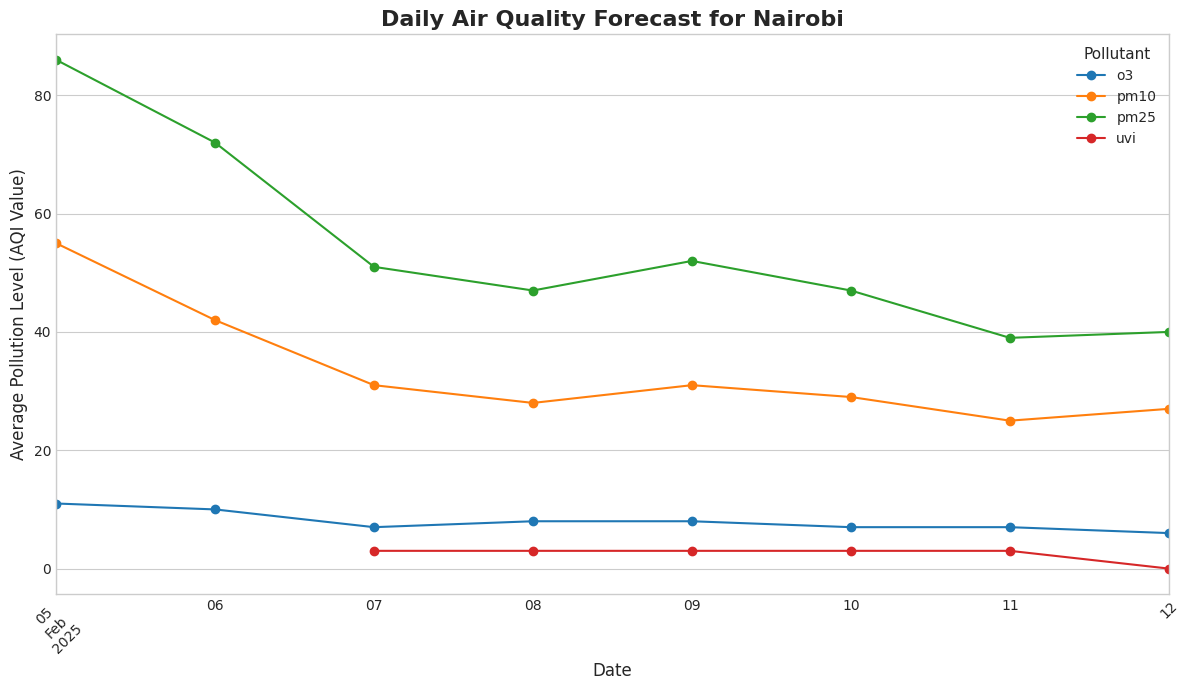

In [22]:
import matplotlib.pyplot as plt 

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')

df_forecast_pivot.plot(figsize=(12, 7), marker="o", linestyle='-')

plt.title("Daily Air Quality Forecast for Nairobi", fontsize=16, weight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Average Pollution Level (AQI Value)", fontsize=12)
plt.legend(title="Pollutant", title_fontsize='11', fontsize='10')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<h3 style="color: #3498db;">3.3. Which pollutant is forecasted to be the most dominant?</h3>
By finding the maximum average value for each pollutant, we can identify which one poses the greatest potential concern during the forecast period.

In [23]:
print("--- Maximum Daily Average Values for Each Pollutant ---")
max_values = df_forecast_pivot.max()
print(max_values)

# Find the pollutant with the overall highest value
worst_pollutant = max_values.idxmax()
print(f"\nBased on the maximum average value, '{worst_pollutant}' is the most dominant pollutant.")

--- Maximum Daily Average Values for Each Pollutant ---
pollutant
o3      11.0
pm10    55.0
pm25    86.0
uvi      3.0
dtype: float64

Based on the maximum average value, 'pm25' is the most dominant pollutant.


<h3 style="color: #3498db;">3.4. Which pollutant is the most volatile?</h3>
Volatility, measured by standard deviation, tells us which pollutant's levels are most inconsistent or fluctuating. A highly volatile pollutant might indicate intermittent emission sources.

In [24]:
print("--- Pollutant Variability (Standard Deviation) ---")
variability = df_forecast_pivot.std().sort_values(ascending=False)
print(variability)
print(f"\n'{variability.idxmax()}' is the most volatile pollutant.")

--- Pollutant Variability (Standard Deviation) ---
pollutant
pm25    16.385970
pm10    10.085350
o3       1.690309
uvi      1.224745
dtype: float64

'pm25' is the most volatile pollutant.


<h3 style="color: #3498db;">3.5. Do the pollutant levels move together?</h3>
A correlation analysis helps us understand the relationships <em>between</em> pollutants. A strong positive correlation suggests that two pollutants likely share a common source or are influenced by the same environmental factors. A heatmap is an excellent way to visualize this.


--- Correlation Matrix of Pollutants ---


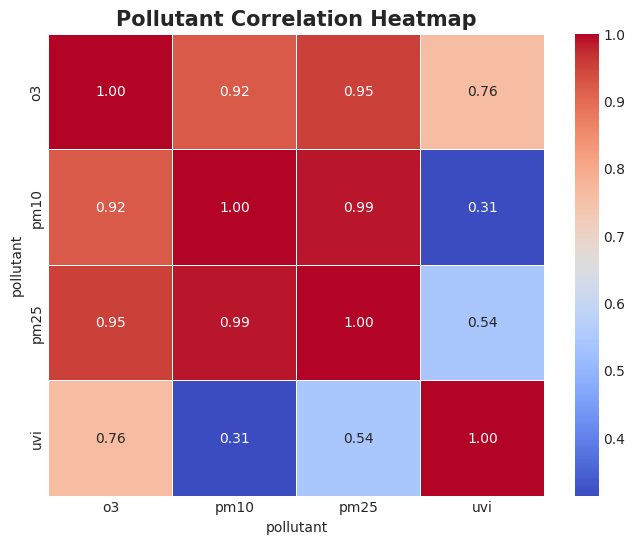

In [27]:
import seaborn as sns

print("\n--- Correlation Matrix of Pollutants ---")
correlation_matrix = df_forecast_pivot.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap='coolwarm', 
    fmt=".2f", 
    linewidths=.5
)
plt.title("Pollutant Correlation Heatmap", fontsize=15, weight='bold')
plt.show()

<h2 style="color: #3498db; border-bottom: 2px solid #ccc; padding-bottom: 8px;">4. Summary of Findings & Actionable Insights</h2>

Based on our exploratory analysis of the air quality forecast for Nairobi, we can draw several initial conclusions.

<div style="font-family: 'Segoe UI', 'Helvetica Neue', Arial, sans-serif; line-height: 1.6; width: 95%;">

<div style="background-color: #f0f8ff; color: #34495e; border-left: 5px solid #5dade2; padding: 15px; border-radius: 5px; margin-top: 15px;">
<h3 style="color: #2c3e50; margin-top: 0;">Summary of Findings:</h3>
<ul style="padding-left: 20px;">
    <li><strong>Dominant Pollutants:</strong> Particulate matter, specifically <code style="background-color: transparent; color: #2980b9; font-weight: bold;">PM2.5</code> and <code style="background-color: transparent; color: #2980b9; font-weight: bold;">PM10</code>, are the most significant pollutants, with PM2.5 reaching the highest average daily value.</li>
    <li><strong>High Correlation:</strong> There is a very strong positive correlation between <code style="background-color: transparent; color: #2980b9; font-weight: bold;">PM2.5</code> and <code style="background-color: transparent; color: #2980b9; font-weight: bold;">PM10</code>. This strongly suggests they originate from common sources like vehicle exhaust or dust.</li>
    <li><strong>Volatility:</strong> <code style="background-color: transparent; color: #2980b9; font-weight: bold;">PM2.5</code> is also the most volatile pollutant, indicating its levels fluctuate more significantly day-to-day.</li>
    <li><strong>Overall Trend:</strong> The line plot shows a general downward trend for particulate matter after an initial peak, suggesting that air quality is forecasted to improve.</li>
    <li><strong>Worst Air Quality Day:</strong> The first day of the forecast, <strong>2025-02-05</strong>, is projected to have the worst overall air quality.</li>
</ul>
</div>

<div style="background-color: #f1f8e9; color: #34495e; border-left: 5px solid #66bb6a; padding: 15px; border-radius: 5px; margin-top: 20px;">
<h3 style="color: #2c3e50; margin-top: 0;">Actionable Insights & Next Steps:</h3>
<p>This EDA provides a solid foundation for more targeted investigations. The following questions would be logical next steps:</p>
<ol style="padding-left: 20px;">
    <li><strong>Source Investigation:</strong> What are the primary emission sources for PM2.5 and PM10 in Nairobi? Can we correlate spikes with traffic data or weather events?</li>
    <li><strong>Weekday vs. Weekend Analysis:</strong> Is there a discernible pattern in pollution levels between weekdays and weekends that could quantify the impact of traffic?</li>
    <li><strong>Health Impact Assessment:</strong> How do the forecasted peak levels compare to World Health Organization (WHO) guidelines?</li>
    <li><strong>Predictive Modeling:</strong> Could we build a model using this data to predict high-pollution days with greater accuracy?</li>
</ol>
</div>

</div>